# Denoising Autoencoder
Denoising autoencoders solve this problem by corrupting the input data on purpose, adding noise or masking some of the input values.

Ref: https://dl.acm.org/doi/pdf/10.1145/1390156.1390294

In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Dataset

In [3]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data', train=True, download=True,
                    transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data', train=False, transform=transforms.ToTensor()),
    batch_size=1
)

Files already downloaded and verified


# Model

In [4]:
from utils import ConvAE

model = ConvAE().to(device)

In [5]:
import torch.nn as nn

# Binary Cross Entropy
# criterion = nn.BCELoss()

# Mean squared error (best for denoising)
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Helper Functions

In [7]:
def np_img_to_tensor(image):
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform = transforms.ToTensor()
    tensor = transform(image)
    return tensor

def tensor_to_np_img(image):
    # image.permute(1,0,2)
    image = transforms.ToPILImage()(image)
    image = np.array(image)
    # image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    return image

# Function to Select Random Perturbation

In [103]:
import transformations as trans

def add_perturbation_from_tensor(inputs, size = 0.3):

    transform_PIL = transforms.ToPILImage()
    transform_tensor = transforms.ToTensor()
    perturbed_imgs = []

    # List of perturbation functions
    opts_perturbation = [
        trans.brighten, trans.darken, trans.add_shadow,
        trans.add_rain, trans.add_snow
    ]

    # List of arguments for perturbation functions
    opts_args = [
        1 * size, 1 * size, 2,
        10, 1 * size
    ]
    
    # process batch
    for img in inputs:
        img = transform_PIL(img)
        img = np.array(img)

        # select random perturbation
        pert_id = np.random.randint(0, len(opts_perturbation))
        print("Perturbation: ", opts_perturbation[pert_id], opts_args[pert_id])
        perturbed_img = opts_perturbation[pert_id](img, opts_args[pert_id])

        perturbed_img = transform_tensor(perturbed_img)
        perturbed_imgs.append(perturbed_img)
    
    perturbed_imgs = torch.cat(perturbed_imgs, 0)

    # NOTE: Size of original Images
    perturbed_imgs = perturbed_imgs.view(inputs.shape[0], 3, 32, 32)
    return perturbed_imgs

# Test Random Perturbations 
Transformations are made at CPU level

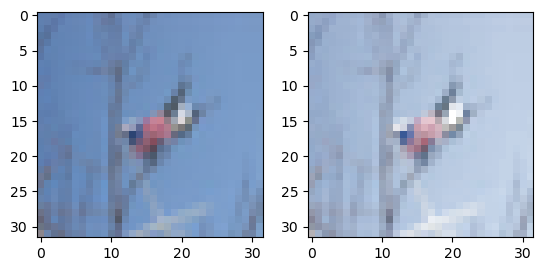

In [85]:
img_list = next(iter(train_loader))
img_list = img_list[0][0:1]

img_np = tensor_to_np_img(img_list[0])
plt.subplot(121)
plt.imshow(img_np)

img_list = add_perturbation_from_tensor(img_list, 0.3)

img = tensor_to_np_img(img_list[0])
plt.subplot(122)
plt.imshow(img)
plt.show()

# Training

In [86]:
n_epochs = 10

for epoch in range(n_epochs):
    train_loss = 0.0

    for images, labels in train_loader:

        # Here is the magic (I suppose)
        images = add_perturbation_from_tensor(images, size = 0.3)   # Size: is the severity of perturbation

        images = images.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    
     # Validation
    valid_loss = 0.0
    model.eval() 
    for images, labels in test_loader:
        images = images.cuda()
        outputs = model(images)
        loss = criterion(outputs, images)
        valid_loss += loss.item()*images.size(0)

    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(test_loader)}')
            

Epoch 1 		 Training Loss: 0.05661952586502542 		 Validation Loss: 0.0013568356013518496
Epoch 2 		 Training Loss: 0.05557321528627067 		 Validation Loss: 0.001352307837868284
Epoch 3 		 Training Loss: 0.05514879864107243 		 Validation Loss: 0.002299444850729196
Epoch 4 		 Training Loss: 0.05461021137119331 		 Validation Loss: 0.0014184704542451073
Epoch 5 		 Training Loss: 0.054052428047453374 		 Validation Loss: 0.0013413877663770108
Epoch 6 		 Training Loss: 0.05400489491511253 		 Validation Loss: 0.0013099839245362091
Epoch 7 		 Training Loss: 0.05347524508500206 		 Validation Loss: 0.0013212669401567838
Epoch 8 		 Training Loss: 0.053297463966556186 		 Validation Loss: 0.0013959867756144376
Epoch 9 		 Training Loss: 0.05279522953210583 		 Validation Loss: 0.001304001808122848
Epoch 10 		 Training Loss: 0.05284091151812217 		 Validation Loss: 0.001294645924391807


# Visualizations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Perturbation:  <function brighten at 0x000001DB11BF1F70> 0.3


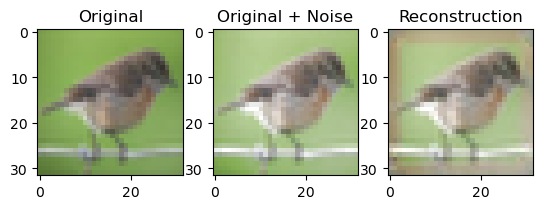

Perturbation:  <function add_rain at 0x000001DB1862B550> 10


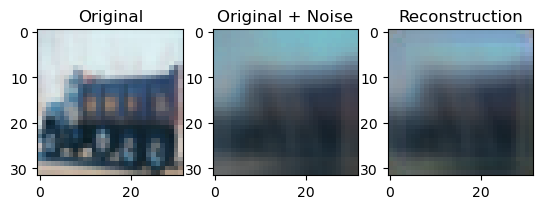

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Perturbation:  <function add_shadow at 0x000001DB1862B280> 2


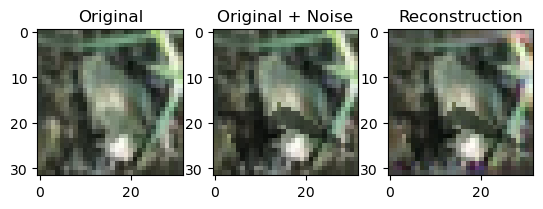

Perturbation:  <function add_rain at 0x000001DB1862B550> 10


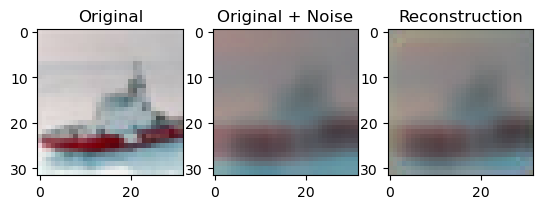

Perturbation:  <function darken at 0x000001DB1862B040> 0.3


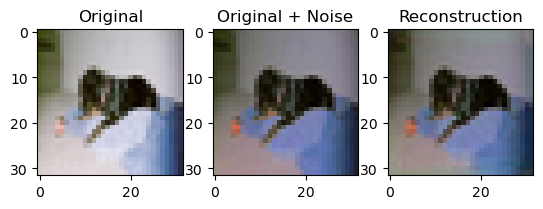

In [110]:
model.eval()
imgs_to_show = 5

with torch.no_grad():
    for data in random.sample(list(test_loader), imgs_to_show):
        plt.figure()
        # Original
        imgs, _ = data
        imgs = imgs.to(device)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(131)
        plt.title("Original")
        plt.imshow((img * 255).astype(np.uint8))

        # Original + Noise
        imgs, _ = data
        img = add_perturbation_from_tensor(imgs, 0.3)
        img_ = np.transpose(img[0].cpu().numpy(), [1,2,0])
        plt.subplot(132)
        plt.title("Original + Noise")
        plt.imshow((img_ * 255).astype(np.uint8))


        # Reconstruction
        img = img.to(device)
        out = model(img)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(133)
        outimg = np.squeeze(outimg)
        # plt.imshow((outimg * 255).astype(np.uint8))
        plt.imshow(outimg)


        plt.title("Reconstruction")
        plt.show()